## CausalANOVA Implementation

In [63]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import class_FM as FM
import rpy2.robjects as ro

from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from sklearn import preprocessing

In [65]:
# Import required R packages
utils = importr('utils')
utils.chooseCRANmirror(ind=66)
utils.install_packages('FindIt')
base = importr("base")
findit = importr("FindIt")

R[write to console]: trying URL 'https://cran.uib.no/src/contrib/FindIt_1.2.0.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 150340 bytes (146 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R

### Initialize factorial model and sample dataset

In [66]:
n = 1000
k = 3
degree = 3
sigma = 0.1
sparsity = 0.5

fm = FM.FactorialModel(
    n=n,
    k=k,
    degree=degree,
    sigma=sigma,
    sparsity=sparsity,
    beta_seed=42,
)
t, y = fm.sample(seed=0)

### Fit OLS model with sample data

In [67]:
pf = preprocessing.PolynomialFeatures(
    degree=degree, interaction_only=True, include_bias=True,
)
T = pf.fit_transform(t)
m = sm.OLS(y, T)
results = m.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 2.093e+04
Date:                Mon, 25 Mar 2024   Prob (F-statistic):               0.00
Time:                        09:55:37   Log-Likelihood:                 881.00
No. Observations:                1000   AIC:                            -1746.
Df Residuals:                     992   BIC:                            -1707.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0085      0.009      0.964      0.3

### Fit CausalANOVA model with sample data

In [68]:
# Convert NumPy arrays to pandas DataFrame
data = pd.DataFrame(t.astype("str"), columns=["t1", "t2", "t3"], dtype="category")
data["outcome"] = y

# Convert pandas DataFrame to R data.frame
with localconverter(ro.default_converter + pandas2ri.converter):
    r_data = ro.conversion.py2rpy(data)

ro.globalenv["r_data"] = r_data

fac_level = ro.IntVector([2, 2, 2])
ro.globalenv["fac_level"] = fac_level

_ = ro.r(
    """
fit <- CausalANOVA(formula=outcome ~ t1 + t2 + t3, family="gaussian", data=r_data, nway=3)
"""
)
print(ro.r("summary(fit)"))


Check: the number of levels for factors and whether they are ordered.
   levels ordered
t1      2   FALSE
t2      2   FALSE
t3      2   FALSE

Analyzing all two-way and three-way interactions...
 
Model:
 outcome ~ . * . * .
<environment: 0x17f39d548>
******
Range:
******
         range
t1       2.095
t2       0.991
t3       0.019
t1:t2    1.046
t1:t3    0.082
t2:t3    0.019
t1:t2:t3 0.078
*******************************
Average Marginal Effects (AME):
*******************************
 Factor Levels base    AME Std.Err 2.5%CI 97.5%CI
     t1    0.0      2.0954  0.0064 2.0828  2.1080
     t1    1.0  *** 0.0000  0.0000 0.0000  0.0000
     t2    0.0      0.9912  0.0064 0.9786  1.0037
     t2    1.0  *** 0.0000  0.0000 0.0000  0.0000
     t3    0.0      0.0188  0.0064 0.0062  0.0314
     t3    1.0  *** 0.0000  0.0000 0.0000  0.0000

********************************************
Average Marginal Interaction Effects (AMIE):
********************************************
Two-way Interactions:
 F

In [110]:
# Compute intercept and coefs of CausalANOVA model
intercept = ro.r("fit$intercept")
coefs = ro.r("fit$coefs")

In [111]:
# Create array of coefficients representing AMIEs
num_coefs = len(coefs) + 1
AMIEs = np.full(num_coefs, intercept[0])
for i in range(num_coefs - 1):
    AMIEs[i] = coefs[i][-1]
print(AMIEs)

[-1.0477065  -0.4955793  -0.00938642 -0.52292408 -0.04110023 -0.00967245
 -0.03905588 -1.00948974]


### Compute expected outcomes from OLS model betas

In [118]:
# Compute expected outcomes as linear combination of betas
betas = results.params
beta_mask = pf.fit_transform(pf.powers_)
expected_outcomes = beta_mask @ betas
print(expected_outcomes)

[ 0.00854169 -1.03693452  0.00446431  0.01320234 -2.9764847  -1.0404512
  0.1266586  -3.17491494]


### Plot betas, AMIEs and expected outcomes

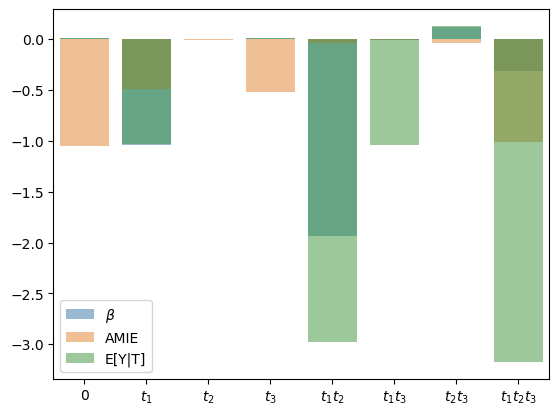

In [119]:
_ = sns.barplot(
    x=[
        r"0",
        r"$t_1$",
        r"$t_2$",
        r"$t_3$",
        r"$t_1 t_2$",
        r"$t_1 t_3$",
        r"$t_2 t_3$",
        r"$t_1 t_2 t_3$",
    ],
    y=betas,
    alpha=0.5,
    label=r"$\beta$",
)

_ = sns.barplot(
    x=[
        r"0",
        r"$t_1$",
        r"$t_2$",
        r"$t_3$",
        r"$t_1 t_2$",
        r"$t_1 t_3$",
        r"$t_2 t_3$",
        r"$t_1 t_2 t_3$",
    ],
    y=AMIEs,
    alpha=0.5,
    label=r"AMIE",
)

_ = sns.barplot(
    x=[
        r"0",
        r"$t_1$",
        r"$t_2$",
        r"$t_3$",
        r"$t_1 t_2$",
        r"$t_1 t_3$",
        r"$t_2 t_3$",
        r"$t_1 t_2 t_3$",
    ],
    y=expected_outcomes,
    alpha=0.5,
    label=r"E[Y|T]",
)